In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np

In [5]:
import fitsio

In [6]:
#Datos ordenados segun TARGETID. 
data_tru = fitsio.read('/home/sd.lobo251/Documents/dc17b/data_true_mod.fits') 
data_tar = fitsio.read('/home/sd.lobo251/Documents/dc17b/data_tar_mod.fits')

In [7]:
print('Field names in data_tru: \n')
for name in data_tru.dtype.names:
    print('{:16}'.format(name))

Field names in data_tru: 

TARGETID        
MOCKID          
CONTAM_TARGET   
TRUEZ           
TRUESPECTYPE    
TEMPLATETYPE    
TEMPLATESUBTYPE 
TEMPLATEID      
SEED            
MAG             
FLUX_G          
FLUX_R          
FLUX_Z          
FLUX_W1         
FLUX_W2         
OIIFLUX         
HBETAFLUX       
TEFF            
LOGG            
FEH             


In [8]:
print('Field names in data_tar: \n')
for name in data_tar.dtype.names:
    print('{:16}'.format(name))

Field names in data_tar: 

TARGETID        
BRICKNAME       
BRICK_OBJID     
RA              
DEC             
FLUX_G          
FLUX_R          
FLUX_Z          
FLUX_W1         
FLUX_W2         
SHAPEEXP_R      
SHAPEEXP_E1     
SHAPEEXP_E2     
SHAPEDEV_R      
SHAPEDEV_E1     
SHAPEDEV_E2     
PSFDEPTH_G      
PSFDEPTH_R      
PSFDEPTH_Z      
GALDEPTH_G      
GALDEPTH_R      
GALDEPTH_Z      
MW_TRANSMISSION_G
MW_TRANSMISSION_R
MW_TRANSMISSION_Z
MW_TRANSMISSION_W1
MW_TRANSMISSION_W2
BRICKID         
DESI_TARGET     
BGS_TARGET      
MWS_TARGET      
HPXPIXEL        
SUBPRIORITY     
OBSCONDITIONS   
CHI2            
COEFF           
Z               
ZERR            
ZWARN           
SPECTYPE        
SUBTYPE         
DELTACHI2       


In [9]:
# Arreglos con los datos de REDSHIFT TRUE y TARGET
true_Z= data_tru['TRUEZ']
tar_Z = data_tar['Z']

print('Len true_Z : {}\nLen tar_Z : {}'.format(len(true_Z), len(tar_Z)))

Len true_Z : 2131896
Len tar_Z : 2131896


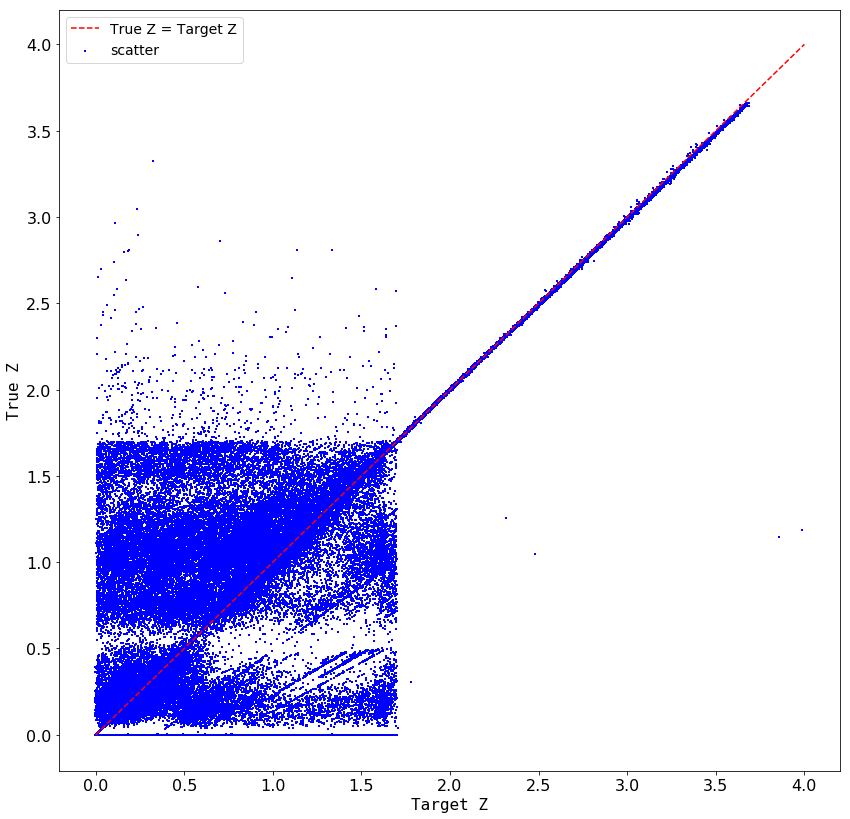

In [10]:
#Relacion entre TARGET Z y TRUE Z. 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(14, 14))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(tar_Z, true_Z, marker='+', s=5, color='b')
ax.legend(('True Z = Target Z', 'scatter'), fontsize=14)
ax.set_ylabel('True Z', fontsize=16, fontname='monospace')
ax.set_xlabel('Target Z', fontsize=16, fontname='monospace')
tick_params(axis='both', which='major', labelsize=16)

In [11]:
#estadísticas de TRUE_Z y MAGNITUDE
from scipy import stats
magnitude = data_tru['MAG']
print(stats.describe(abs(true_Z)))
print(stats.describe(magnitude))


DescribeResult(nobs=2131896, minmax=(0.0, 3.658788), mean=0.63839346, variance=0.27866265, skewness=1.3331096172332764, kurtosis=2.96725636522575)
DescribeResult(nobs=2131896, minmax=(2.19822, 25.0261), mean=20.1918, variance=3.29643, skewness=-0.29287204146385193, kurtosis=0.7103611336198803)


# Nueva tabla con Id, mag, TrueZ y Z para ordenarla y hacer el histograma. 

In [12]:
# Probando una forma diferente de abrir el archivo para reordenarlo
fits_tru = fitsio.FITS('/home/sd.lobo251/Documents/dc17b/data_true_mod.fits')
# Se aisla las columnas de TARGETID, MAG y TRUEZ en un nuevo archivo
tru_mag_with_id = fits_tru[1]['TARGETID', 'MAG', 'TRUEZ'][:]

In [13]:
# Igual que la celda de arriba pero para los datos tARGET
fits_tar = fitsio.FITS('/home/sd.lobo251/Documents/dc17b/data_tar_mod.fits')
tar_z = fits_tar[1]['Z'][:]

In [14]:
#Creamos un solo archivo uniendo tru_mag_with_id y tar_z
from numpy.lib.recfunctions import append_fields

magnitudes_Z = append_fields(tru_mag_with_id, 'Z', tar_z, usemask=False)

In [15]:
# Ordenamos la tabla FITS 'magnitudes_Z' según la columna de MAGNITUD
magnitudes_Z.sort(order='MAG')

In [16]:
magnitudes_Z[0:5]

array([(288230408724718789, -1.5473704e-05, 2.19822, -1.40404791e-05),
       (288230402005409031,  7.7594012e-07, 3.34669,  1.40525757e-06),
       (288230426516919074, -1.4716615e-05, 3.87593, -1.31871519e-05),
       (288230408863094438, -2.5252002e-05, 4.27218, -2.40412523e-05),
       (288230494879910126,  8.9394511e-05, 4.44423,  9.02894620e-05)],
      dtype=[('TARGETID', '>i8'), ('TRUEZ', '>f4'), ('MAG', '>f4'), ('Z', '>f8')])

In [17]:
# Se calucla el error entre el TRUE_Z y el TARGET_Z y se clasifica segun sea menor al 1%, al 5%, al 10%, o mayor.
# si el error es menor a cierto valor, se cuenta como un 1 en el respectivo valor. 

#arreglo para guardar los resultados de la evaluación de error.
count = zeros((len(magnitudes_Z)), dtype=[('10%', 'int32'), ('5%', 'int32'), ('1%', 'int32')])
for i, line in enumerate(magnitudes_Z):
    truez = line[1]
    tarz  = line[3]
    if truez != 0: error = abs(truez - tarz)/abs(truez)
    else : error = abs(truez - tarz)
    if error < 0.1:
        count['10%'][i] = 1
        if error < 0.05:
            count['5%'][i] = 1
            if error < 0.01:
                count['1%'][i] = 1


In [18]:
from numpy.lib.recfunctions import merge_arrays
# Ahora unimos a la tabla de 'magnitud_Z, las columnas que indican en cuál rango de error se encuenta la diferencian entre
# TRUEZ y TARZ
datos_histograma = merge_arrays((magnitudes_Z, count), asrecarray=True, flatten=True)

In [19]:
def compute_errors(datos):
    count = zeros((len(datos)), dtype=[('10%', 'int32'), ('5%', 'int32'), ('1%', 'int32')])
    for i, line in enumerate(datos):
        truez = line['TRUEZ']
        tarz  = line['Z']
        if truez != 0: error = abs(truez - tarz)/abs(truez)
        else : error = abs(truez - tarz)
        if error < 0.1:
            count['10%'][i] = 1
            if error < 0.05:
                count['5%'][i] = 1
                if error < 0.01:
                    count['1%'][i] = 1
    to_return = merge_arrays((datos, count), asrecarray=True, flatten=True)
    return to_return

In [20]:
datos_histograma[0:10]

rec.array([(288230408724718789, -1.5473704e-05, 2.19822, -1.40404791e-05, 1, 0, 0),
           (288230402005409031,  7.7594012e-07, 3.34669,  1.40525757e-06, 0, 0, 0),
           (288230426516919074, -1.4716615e-05, 3.87593, -1.31871519e-05, 0, 0, 0),
           (288230408863094438, -2.5252002e-05, 4.27218, -2.40412523e-05, 1, 1, 0),
           (288230494879910126,  8.9394511e-05, 4.44423,  9.02894620e-05, 1, 1, 0),
           (288230494867327216, -1.6491676e-05, 4.65242, -1.30584209e-05, 0, 0, 0),
           (288230402022186515,  3.9586386e-05, 4.69957,  4.02120011e-05, 1, 1, 0),
           (288230394384356812,  8.5539512e-05, 4.8079 ,  8.81612058e-05, 1, 1, 0),
           (288230404555569089,  9.1908580e-05, 4.89583,  9.73034908e-05, 1, 0, 0),
           (288230376713768290,  3.5755071e-05, 4.93649,  3.60923326e-05, 1, 1, 1)],
          dtype=[('TARGETID', '>i8'), ('TRUEZ', '>f4'), ('MAG', '>f4'), ('Z', '>f8'), ('10%', '<i4'), ('5%', '<i4'), ('1%', '<i4')])

In [21]:
#funcion para crear las listas que después serán graficadas.
def generate_hist(n_bins, min_value, max_value, datos):
    
    ran = (max_value - min_value)/n_bins
    his_1 = zeros(n_bins)
    his_5 = zeros(n_bins)
    his_10 = zeros(n_bins)
    
    tot_his = zeros(n_bins)

    start = min_value #*( 1 - sign(min_value)/100)
    j = 0
    
    #Se recorren los datos y se le suma a hist_1, hist_5 o hist_10 según sea el error. 
    for i in range(n_bins):
        
        if i == n_bins - 1:
            start += start/100
        while datos['MAG'][j] < start + ran :
            tot_his[i] += 1
            if datos['10%'][j] == 1:
                his_10[i] += 1
                if datos['5%'][j] == 1:
                    his_5[i] += 1
                    if datos['1%'][j] == 1:
                        his_1[i] += 1
            j += 1
            if j == len(datos):
                break
            
        start += ran
    
    print(j)
    return tot_his, his_1, his_5, his_10    
        
        
        
    
    

In [23]:
a = [1, 2, 3, 4, 5]
a[0::2]

[1, 3, 5]

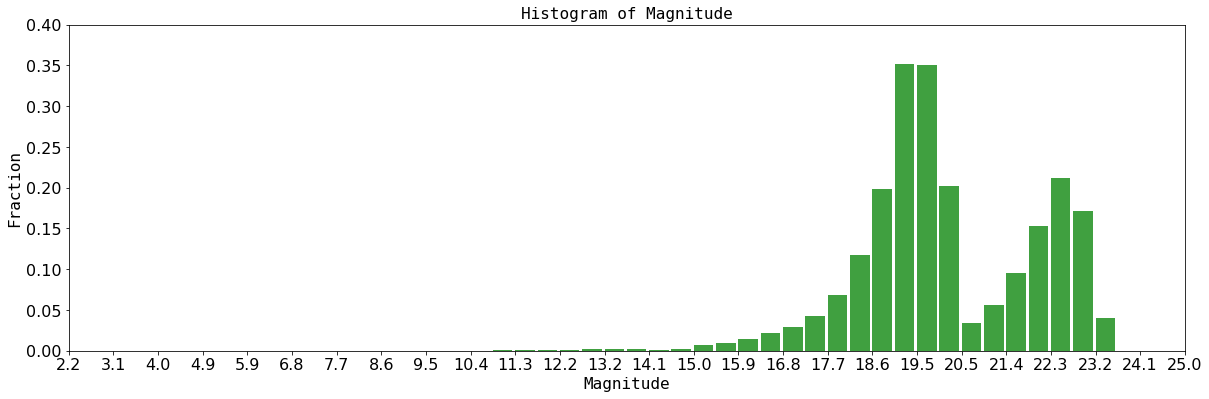

In [72]:
figure(figsize=(20,6))
n, bins, patches = plt.hist(magnitude, 50, (min(magnitude), max(magnitude)), density=True, color = 'g', alpha=0.75, width = 0.40)
plt.xlabel('Magnitude', fontsize=16, fontname='monospace')
plt.ylabel('Fraction', fontsize=16, fontname='monospace')
plt.title('Histogram of Magnitude', fontsize=16, fontname='monospace')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([min(magnitude), max(magnitude), 0, 0.40])
plt.xticks(bins[0::2], [round(i, 1) for i in bins[0::2]])
tick_params(axis='both', which='major', labelsize=16)
#plt.grid(True)

In [29]:
mi = min(datos_histograma['MAG'])
ma = max(datos_histograma['MAG'])
n_bins = 50
tot_his, his_1, his_5, his_10 = generate_hist(n_bins, mi, ma, datos_histograma)

2131896


In [30]:
print('{} {} {} {}'. format(len(tot_his), len(his_1), len(his_5), len(his_10)))

50 50 50 50


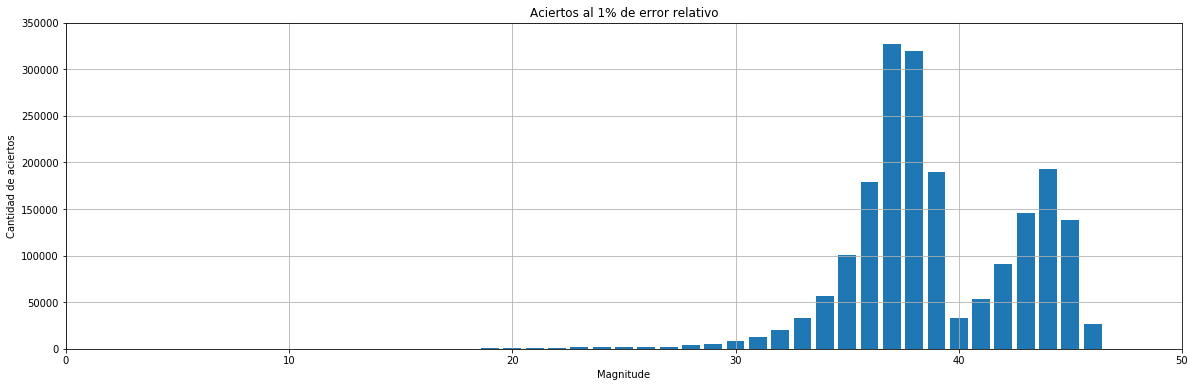

In [31]:
figure(figsize=(20,6))
bar(arange(50),his_1)
plt.xlabel('Magnitude')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 1% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 350000])
#plt.xticks(bins, [round(i, 1) for i in bins])
plt.grid(True)

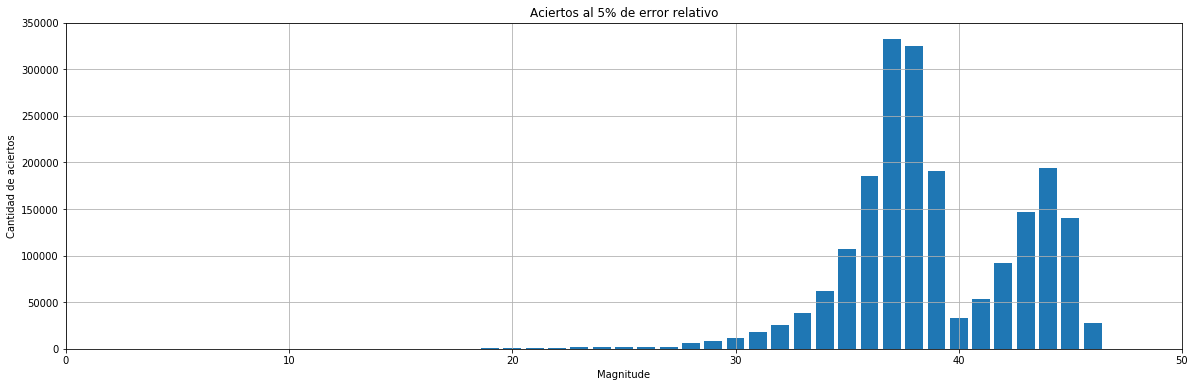

In [32]:
figure(figsize=(20,6))
bar(arange(50),his_5)
plt.xlabel('Magnitude')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 5% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 350000])
#plt.xticks(bins, [round(i, 1) for i in bins])
plt.grid(True)

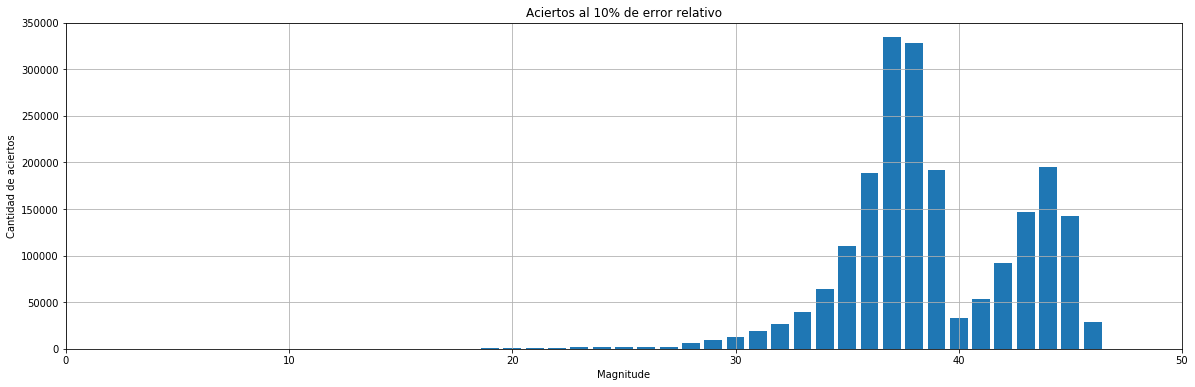

In [33]:
figure(figsize=(20,6))
bar(arange(50),his_10)
plt.xlabel('Magnitude')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 10% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 350000])
#plt.xticks(bins, [round(i, 1) for i in bins])
plt.grid(True)

# Distribución de aciertos por cada intervalo de magnitud:

In [34]:
# se normaliza cada bin segun el numero total de mediciones en cada uno
final_his_1 = zeros(n_bins)
for i in range(n_bins):
    if tot_his[i] != 0:
        final_his_1[i] = his_1[i]/tot_his[i]

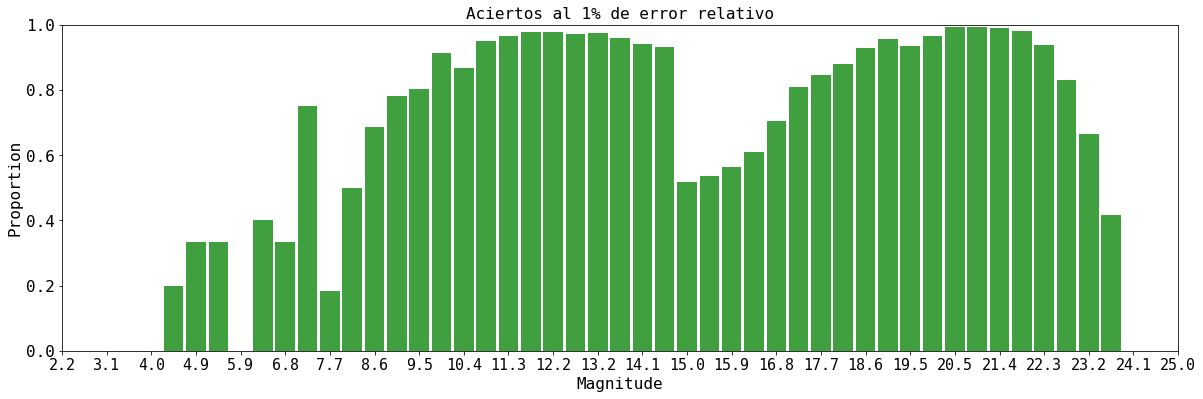

In [73]:
figure(figsize=(20,6))
bar(bins[:-1],final_his_1, width = 0.40, align = 'center', color='g', alpha=0.75)
plt.xlabel('Magnitude', fontsize=16, fontname='monospace')
plt.ylabel('Proportion', fontsize=16, fontname='monospace')
plt.title('Aciertos al 1% de error relativo', fontsize=16, fontname='monospace')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([0, 50, 0, 1.0])
#plt.xticks(arange(0, n_bins ))
plt.axis([min(magnitude), max(magnitude), 0, 1.0])
plt.xticks(bins[0::2], [round(i, 1) for i in bins[0::2]], fontsize=15, fontname='monospace')
yticks(fontsize=16, fontname='monospace')
fontname='monospace'
#plt.grid(True)

In [30]:
final_his_5 = zeros(n_bins)
for i in range(n_bins):
    if tot_his[i] != 0:
        final_his_5[i] = his_5[i]/tot_his[i]


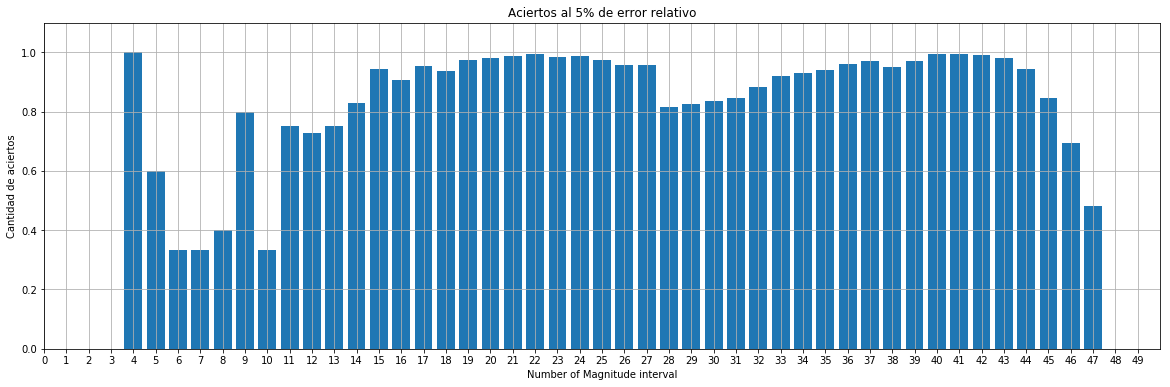

In [31]:
figure(figsize=(20,6))
bar(arange(50),final_his_5)
plt.xlabel('Number of Magnitude interval')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 5% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 1.1])
plt.xticks(arange(0, n_bins ))
plt.grid(True)

In [32]:
final_his_10 = zeros(n_bins)
for i in range(n_bins):
    if tot_his[i] != 0:
        final_his_10[i] = his_10[i]/tot_his[i]


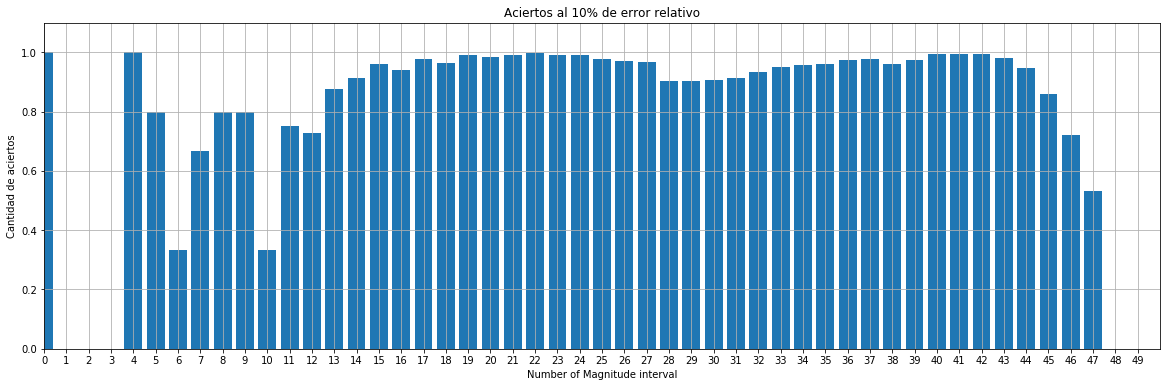

In [33]:
figure(figsize=(20,6))
bar(arange(50),final_his_10)
plt.xlabel('Number of Magnitude interval')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 10% de error relativo')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 1.1])
plt.xticks(arange(0, n_bins ))
plt.grid(True)

# Gráficas por SPECTYPE y TEMPLATETYPE

In [75]:
#discriminación por spectype
tru_table_with_spectype = fits_tru[1]['TARGETID', 'MAG', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE'][:]
tar_table_with_spectype = fits_tar[1]['Z', 'SPECTYPE'][:]
table_with_spectype = merge_arrays((tru_table_with_spectype, tar_table_with_spectype), asrecarray=True, flatten=True)

In [76]:
table_with_spectype[10563: 10573]

rec.array([(288230376193659704,  1.3356692e-05, b'STAR      ', b'STAR      ', b'          ', 17.840328, 1.63089630e-05, b'STAR  '),
           (288230376193659744,  1.8830113e-05, b'STAR      ', b'STAR      ', b'          ', 19.546728, 2.22381114e-05, b'STAR  '),
           (288230376193659764,  8.2907150e-05, b'STAR      ', b'STAR      ', b'          ', 18.867592, 8.47997140e-05, b'STAR  '),
           (288230376193659788,  6.4609812e-05, b'STAR      ', b'STAR      ', b'          ', 15.205178, 6.79663840e-05, b'STAR  '),
           (288230376193659795,  7.7386867e-05, b'STAR      ', b'WD        ', b'DA        ', 19.816   , 2.25580646e-04, b'STAR  '),
           (288230376193659796, -1.2241802e-04, b'STAR      ', b'WD        ', b'DB        ', 18.921   , 7.94768166e-01, b'GALAXY'),
           (288230376193659799,  6.8248016e-01, b'QSO       ', b'QSO       ', b'          ', 22.26522 , 6.81259710e-01, b'QSO   '),
           (288230376193659800,  1.0406685e+00, b'QSO       ', b'QSO       '

In [77]:
n_rows = len(table_with_spectype) 
spectype_GALAXY = []
spectype_QSO = []
spectype_STAR = []

In [78]:
for i in range(n_rows):
    spectype = table_with_spectype['TRUESPECTYPE'][i]
    if  spectype == b'GALAXY    ':
        spectype_GALAXY.append(table_with_spectype[i])
    elif spectype == b'QSO       ':
        spectype_QSO.append(table_with_spectype[i])
    elif spectype == b'STAR      ':
        spectype_STAR.append(table_with_spectype[i])
    else:
        print('el elemento {} es de spectype {}'.format(i, spectype))
        
spectype_GALAXY = array(spectype_GALAXY)
spectype_QSO = array(spectype_QSO)
spectype_STAR = array(spectype_STAR)

In [79]:
len_galaxy = len(spectype_GALAXY)
len_qso = len(spectype_QSO)
len_star = len(spectype_STAR)
print('Galaxy: {}\nQSO: {}\nStar: {}\nTotal: {}'.format(len_galaxy, len_qso, len_star, len_galaxy+len_qso+len_star))

Galaxy: 1796213
QSO: 194319
Star: 141364
Total: 2131896


(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 <a list of 8 Text yticklabel objects>)

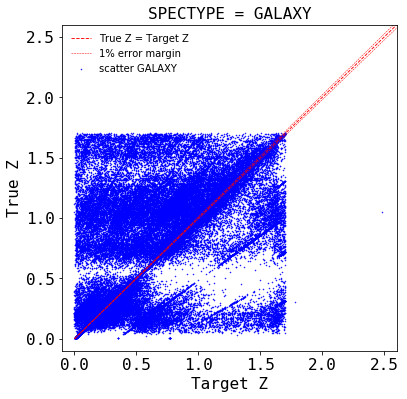

In [120]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= GALAXY. 
x_f = linspace(0, 4.0, 100)
x_l_p = 0.99*x_f
x_l_m = 1.01*x_f

fig, ax = subplots(figsize=(6, 6))
line1, = ax.plot(x_f, x_f, '--', color='r', linewidth=0.9)
line2, = ax.plot(x_f, x_l_p, '--', color='r', linewidth=0.5)
line3, = ax.plot( x_f, x_l_m, '--', color='r', linewidth=0.5)

scatter1 = ax.scatter(spectype_GALAXY['Z'], spectype_GALAXY['TRUEZ'], marker='.', s=1, color='b')
ax.legend(handles=[line1, line2, scatter1], labels=('True Z = Target Z', '1% error margin', 'scatter GALAXY'), fontsize=10, frameon=False)
ax.set_ylabel('True Z',fontsize=16, fontname='monospace' )
ax.set_xlabel('Target Z', fontsize=16, fontname='monospace')
ax.set_title('SPECTYPE = GALAXY', fontsize=16, fontname='monospace')
ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.1, 2.6)
xticks(fontsize=16, fontname='monospace')
yticks(fontsize=16, fontname='monospace')

In [46]:
hist_spectype_GALAXY = compute_errors(spectype_GALAXY)
hist_spectype_GALAXY.sort(order='MAG')
gal_min = min(spectype_GALAXY['MAG'])
gal_max = max(spectype_GALAXY['MAG'])
gal_tot_his, gal_his_1, gal_his_5, gal_his_10 = generate_hist(datos=hist_spectype_GALAXY, max_value=gal_max, min_value=gal_min, n_bins=50)

1796213


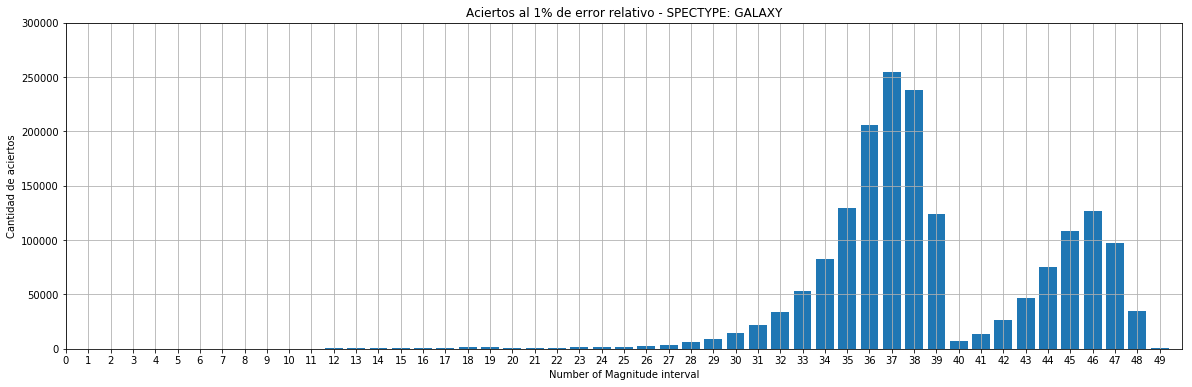

In [47]:
figure(figsize=(20,6))
bar(arange(50),gal_his_1)
plt.xlabel('Number of Magnitude interval')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 1% de error relativo - SPECTYPE: GALAXY')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 300000])
plt.xticks(arange(0, n_bins ))
plt.grid(True)

In [48]:
gal_final_his_1 = zeros(n_bins)
for i in range(n_bins):
    if gal_tot_his[i] != 0:
        gal_final_his_1[i] = gal_his_1[i]/gal_tot_his[i]


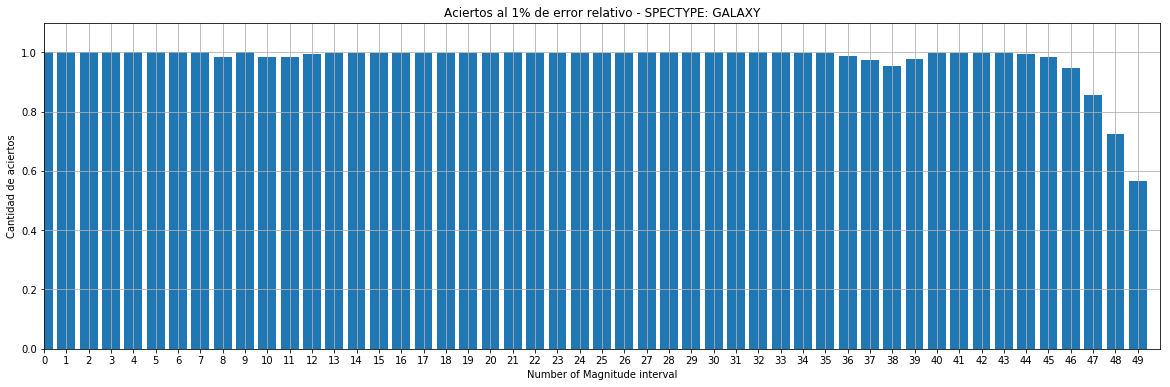

In [49]:
figure(figsize=(20,6))
bar(arange(50),gal_final_his_1)
plt.xlabel('Number of Magnitude interval')
plt.ylabel('Cantidad de aciertos')
plt.title('Aciertos al 1% de error relativo - SPECTYPE: GALAXY')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 50, 0, 1.1])
plt.xticks(arange(0, n_bins ))
plt.grid(True)

In [50]:
print(gal_his_1.sum(), gal_tot_his.sum(), len(spectype_GALAXY), gal_his_1.sum()/gal_tot_his.sum())

1730913.0 1796213.0 1796213 0.9636457368920056


### Para la tipo GALAXY, el 96.36 % de los datos está dentro del 1% de error relativo. Esto se vé en la gráfica siguiente. 

In [51]:
gal_tru_z = []
gal_tar_z = []
for i, line in enumerate(hist_spectype_GALAXY):
    t_z = line['TRUEZ']
    tt_z = line['Z']
    if line['1%'] == 1:
        gal_tru_z.append(t_z)
        gal_tar_z.append(tt_z)


(-0.1, 2.0)

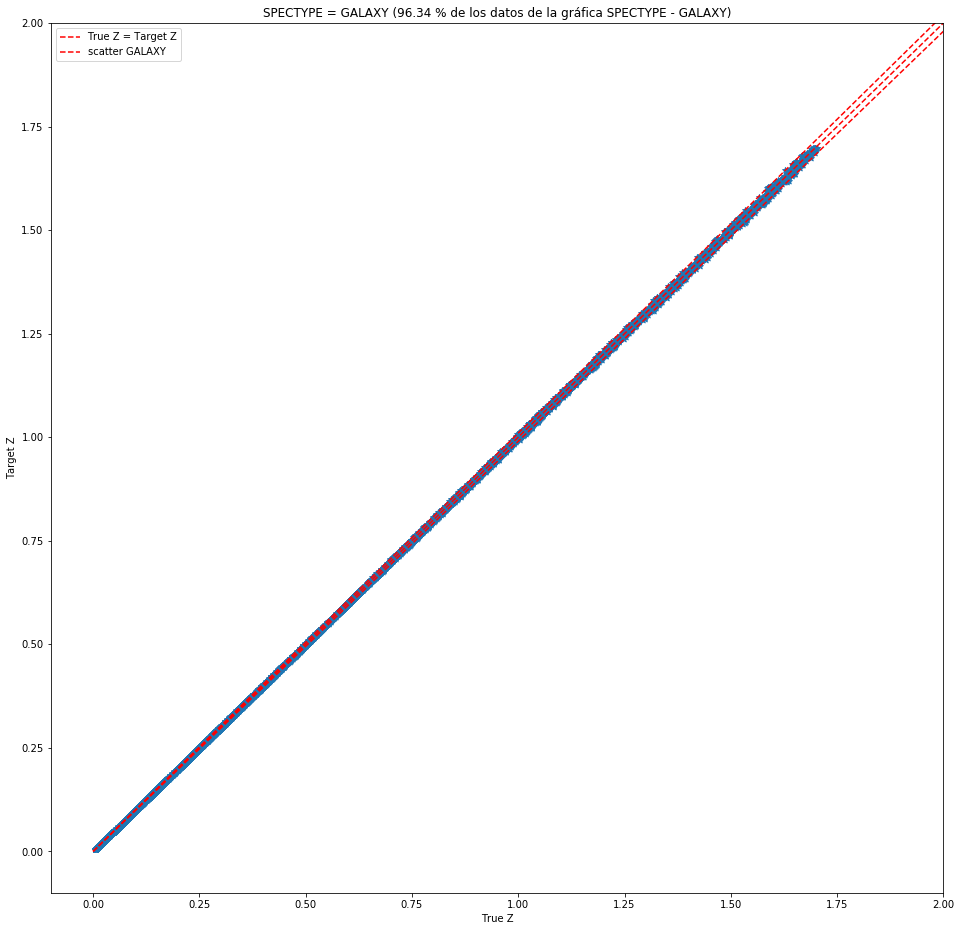

In [52]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE = GALAXY (96.34 % de los datos de la gráfica SPECTYPE - GALAXY). 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(16, 16))
ax.plot(x_f, x_f, '--', color='r')
ax.plot(x_f, x_l_p, '--', color='r')
ax.plot(x_f, x_l_m, '--', color='r')

ax.scatter(gal_tru_z, gal_tar_z, marker='*')
ax.legend(('True Z = Target Z', 'scatter GALAXY'))
ax.set_xlabel('True Z')
ax.set_ylabel('Target Z')
ax.set_title('SPECTYPE = GALAXY (96.34 % de los datos de la gráfica SPECTYPE - GALAXY)')
ax.set_xlim(-0.1, 2.0)
ax.set_ylim(-0.1, 2.0)

# SPECTYPE QSO

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 11 Text yticklabel objects>)

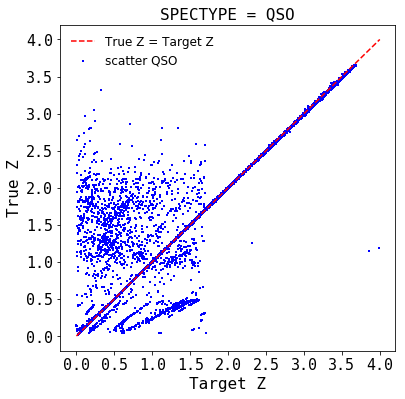

In [123]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= QSO. 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(6, 6))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(spectype_QSO['Z'], spectype_QSO['TRUEZ'], marker='+', color='b', s=3)
ax.legend(('True Z = Target Z', 'scatter QSO'), fontsize=12, frameon=False)
ax.set_ylabel('True Z', fontsize=16, fontname='monospace')
ax.set_xlabel('Target Z', fontsize=16, fontname='monospace')
ax.set_title('SPECTYPE = QSO', fontsize=16, fontname='monospace')
xticks(fontsize=15, fontname='monospace')
yticks(fontsize=15, fontname='monospace')

# SPECTYPE: STAR

(array([-0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,  0.006]),
 <a list of 7 Text yticklabel objects>)

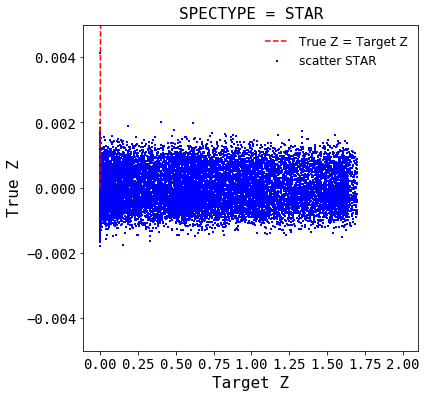

In [129]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= STAR. 
x_f = linspace(0, 2.0, 100)

fig, ax = subplots(figsize=(6, 6))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(spectype_STAR['Z'], spectype_STAR['TRUEZ'], marker='+', color='b', s=3)
ax.legend(('True Z = Target Z', 'scatter STAR'), fontsize=12, frameon=False)
ax.set_ylabel('True Z', fontsize=16, fontname='monospace')
ax.set_xlabel('Target Z', fontsize=16, fontname='monospace')
ax.set_title('SPECTYPE = STAR',fontsize=16, fontname='monospace')
ax.set_ylim(-0.005, 0.005)
xticks(fontsize=14, fontname='monospace')
yticks(fontsize=14, fontname='monospace')

### Entendiendp TEMPLATETYPE y TEMPLATESUBTYPE

In [38]:
unique(data_tru['TEMPLATETYPE'])

array([b'BGS       ', b'ELG       ', b'LRG       ', b'QSO       ',
       b'STAR      ', b'WD        '], dtype='|S10')

In [39]:
unique(data_tru['TEMPLATESUBTYPE'])

array([b'          ', b'A5IV      ', b'A6III     ', b'A6IV      ',
       b'A7IV      ', b'A8V       ', b'A9IV      ', b'DA        ',
       b'DB        ', b'F2III     ', b'F2IV      ', b'F2V       ',
       b'F4IV      ', b'F4V       ', b'F5.5IV    ', b'F5V       ',
       b'F6V       ', b'F7V       ', b'F8IV      ', b'F8V       ',
       b'G0IV      ', b'G0V       ', b'G1V       ', b'G2IV      ',
       b'G3V       ', b'G4V       ', b'G5.5V     ', b'G5V       ',
       b'G6V       ', b'G7V       ', b'G8V       ', b'G9V       ',
       b'K0III     ', b'K0V       ', b'K1III     ', b'K1V       ',
       b'K2V       ', b'K3V       ', b'K4.5V     ', b'K4V       ',
       b'K5III     ', b'K5V       ', b'K6V       ', b'K7III     ',
       b'K7V       ', b'K8V       ', b'K9V       ', b'L0V       ',
       b'L2V       ', b'L3V       ', b'L4V       ', b'L5V       ',
       b'LYA       ', b'M0.5V     ', b'M0V       ', b'M1.5V     ',
       b'M1V       ', b'M2.5V     ', b'M2V       ', b'M3.5V   

## Subclasificación de SPECTYPE:GALAXY en BGS, ELG y LRG

In [110]:
# clasificación de galaxias segun lo anterior: 
galaxy_BGS = []
galaxy_ELG = []
galaxy_LRG = []

for i in range(len_galaxy):
    templatetype = spectype_GALAXY['TEMPLATETYPE'][i]
    if templatetype == b'BGS       ':
        galaxy_BGS.append(spectype_GALAXY[i])
    elif templatetype == b'ELG       ':
        galaxy_ELG.append(spectype_GALAXY[i])  
    elif templatetype == b'LRG       ':
        galaxy_LRG.append(spectype_GALAXY[i])  
    else:
        print('el elemento {} es de spectype {}'.format(i, templatetype))
        
galaxy_BGS = array(galaxy_BGS)
galaxy_ELG = array(galaxy_ELG)
galaxy_LRG = array(galaxy_LRG)

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ]), <a list of 10 Text yticklabel objects>)

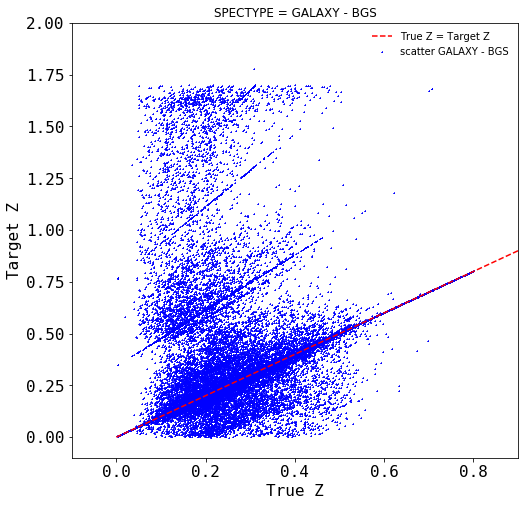

In [136]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= GALAXY - TYPE BGS . 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(8, 8))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(galaxy_BGS['TRUEZ'], galaxy_BGS['Z'], marker='+', s=1, color='b')
ax.legend(('True Z = Target Z', 'scatter GALAXY - BGS'), fontsize=10, frameon = False)
ax.set_xlabel('True Z', fontsize=16, fontname='monospace')
ax.set_ylabel('Target Z', fontsize=16, fontname='monospace')
ax.set_title('SPECTYPE = GALAXY - BGS')
ax.set_xlim(-0.1, 0.9)
ax.set_ylim(-0.1, 2.0)
xticks(fontsize=16, fontname='monospace')
yticks(fontsize=16, fontname='monospace')

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ]), <a list of 10 Text yticklabel objects>)

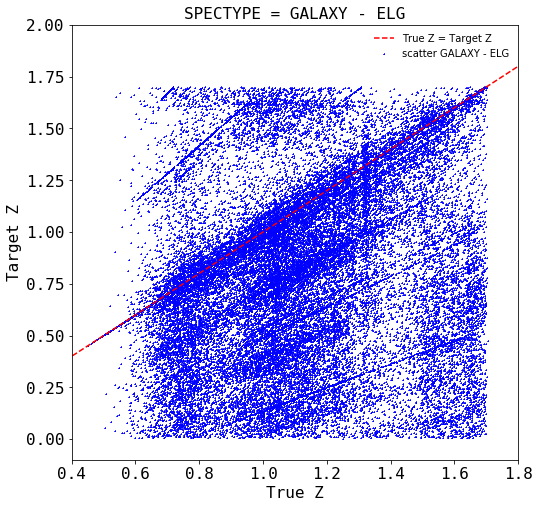

In [135]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= GALAXY - TYPE ELG . 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(8, 8))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(galaxy_ELG['TRUEZ'], galaxy_ELG['Z'],  marker='+', s=1, color='b')
ax.legend(('True Z = Target Z', 'scatter GALAXY - ELG'), fontsize=10, frameon = False)
ax.set_xlabel('True Z', fontsize=16, fontname='monospace')
ax.set_ylabel('Target Z', fontsize=16, fontname='monospace')
ax.set_title('SPECTYPE = GALAXY - ELG', fontsize=16, fontname='monospace')
ax.set_xlim(0.4, 1.8)
ax.set_ylim(-0.1, 2.0)
xticks(fontsize=16, fontname='monospace')
yticks(fontsize=16, fontname='monospace')

(array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 <a list of 8 Text yticklabel objects>)

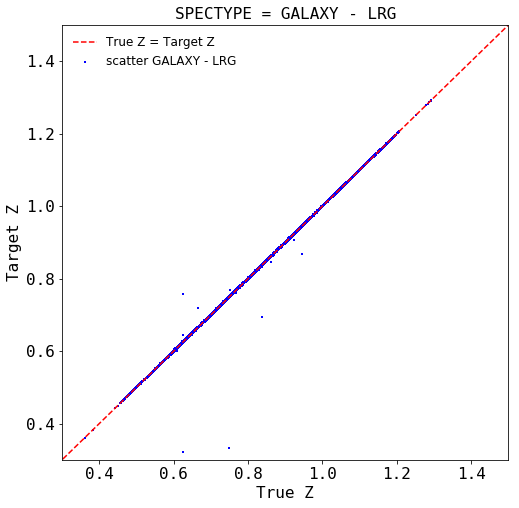

In [140]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= GALAXY - TYPE LRG . 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(8, 8))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(galaxy_LRG['TRUEZ'], galaxy_LRG['Z'],  marker='+', s=4, color='b')
ax.legend(('True Z = Target Z', 'scatter GALAXY - LRG'), fontsize=12, frameon = False)
ax.set_xlabel('True Z', fontsize=16, fontname='monospace')
ax.set_ylabel('Target Z', fontsize=16, fontname='monospace')
ax.set_title('SPECTYPE = GALAXY - LRG', fontsize=16, fontname='monospace')
ax.set_xlim(0.3, 1.5)
ax.set_ylim(0.3, 1.5)
xticks(fontsize=16, fontname='monospace')
yticks(fontsize=16, fontname='monospace')

In [123]:
len_galaxy_BGS = len(galaxy_BGS)
len_galaxy_ELG= len(galaxy_ELG)
len_galaxy_LRG = len(galaxy_LRG)
print('BGS galaxies: {}\nELG galaxies: {}\nLRG galaxies: {}'.format(len_galaxy_BGS, len_galaxy_ELG, len_galaxy_LRG))
print('Total: {}'.format(len_galaxy_BGS+len_galaxy_ELG+len_galaxy_LRG))

BGS galaxies: 889336
ELG galaxies: 601847
LRG galaxies: 305030
Total: 1796213


## Subclasificación de SPECTYPE:STAR en STAR y WD

In [44]:
#clasificación de estrella segun WD o STAR:
star_STAR = []
star_WD = []

for i in range(len_star):
    templatetype = spectype_STAR['TEMPLATETYPE'][i]
    if templatetype == b'STAR      ':
        star_STAR.append(spectype_STAR[i])
    elif templatetype == b'WD        ':
        star_WD.append(spectype_STAR[i])  
    else:
        print('el elemento {} es de spectype {}'.format(i, templatetype))
        
star_STAR = array(star_STAR)
star_WD = array(star_WD)

(-0.05, 1.8)

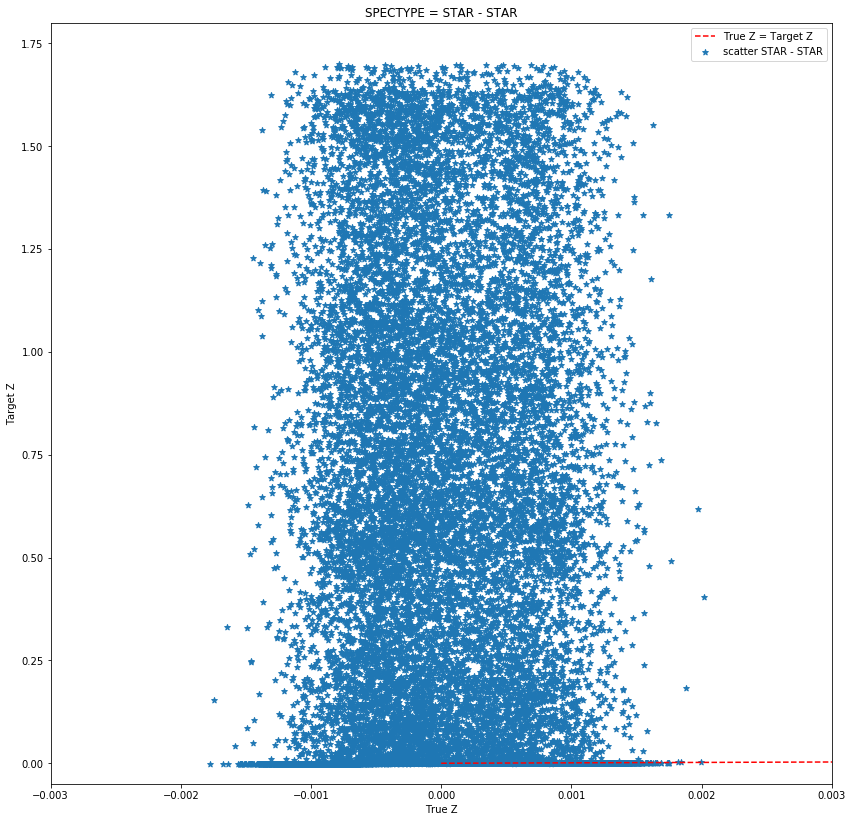

In [53]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= STAR - TYPE STAR . 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(14, 14))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(star_STAR['TRUEZ'], star_STAR['Z'], marker='*')
ax.legend(('True Z = Target Z', 'scatter STAR - STAR'))
ax.set_xlabel('True Z')
ax.set_ylabel('Target Z')
ax.set_title('SPECTYPE = STAR - STAR')
ax.set_xlim(-0.003, 0.003)
ax.set_ylim(-0.05, 1.8)

(-0.05, 1.8)

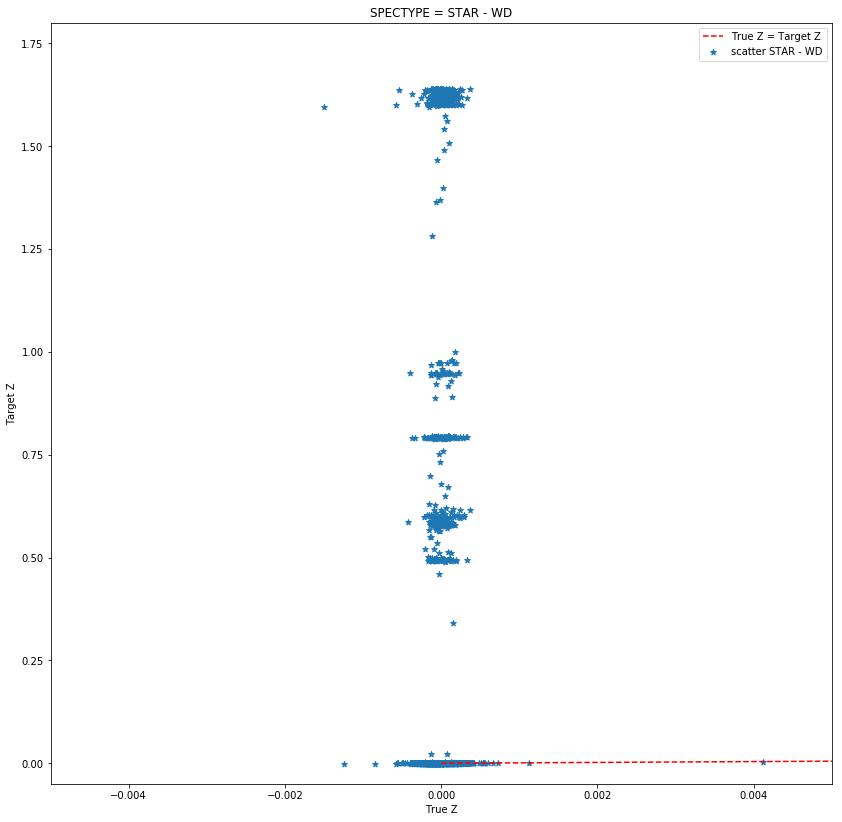

In [66]:
#Relacion entre TARGET Z y TRUE Z para SPECTYPE= STAR - TYPE WD . 
x_f = linspace(0, 4.0, 100)

fig, ax = subplots(figsize=(14, 14))
ax.plot(x_f, x_f, '--', color='r')
ax.scatter(star_WD['TRUEZ'], star_WD['Z'], marker='*')
ax.legend(('True Z = Target Z', 'scatter STAR - WD'))
ax.set_xlabel('True Z')
ax.set_ylabel('Target Z')
ax.set_title('SPECTYPE = STAR - WD')
ax.set_xlim(-0.005, 0.005)
ax.set_ylim(-0.05, 1.8)

In [75]:
unique(spectype_STAR['TEMPLATESUBTYPE'])

array([b'          ', b'A5IV      ', b'A6III     ', b'A6IV      ',
       b'A7IV      ', b'A8V       ', b'A9IV      ', b'DA        ',
       b'DB        ', b'F2III     ', b'F2IV      ', b'F2V       ',
       b'F4IV      ', b'F4V       ', b'F5.5IV    ', b'F5V       ',
       b'F6V       ', b'F7V       ', b'F8IV      ', b'F8V       ',
       b'G0IV      ', b'G0V       ', b'G1V       ', b'G2IV      ',
       b'G3V       ', b'G4V       ', b'G5.5V     ', b'G5V       ',
       b'G6V       ', b'G7V       ', b'G8V       ', b'G9V       ',
       b'K0III     ', b'K0V       ', b'K1III     ', b'K1V       ',
       b'K2V       ', b'K3V       ', b'K4.5V     ', b'K4V       ',
       b'K5III     ', b'K5V       ', b'K6V       ', b'K7III     ',
       b'K7V       ', b'K8V       ', b'K9V       ', b'L0V       ',
       b'L2V       ', b'L3V       ', b'L4V       ', b'L5V       ',
       b'M0.5V     ', b'M0V       ', b'M1.5V     ', b'M1V       ',
       b'M2.5V     ', b'M2V       ', b'M3.5V     ', b'M3V     

In [74]:
unique(spectype_GALAXY['TEMPLATESUBTYPE'])

array([b'          '], dtype='|S10')

In [73]:
unique(spectype_QSO['TEMPLATESUBTYPE'])

array([b'          ', b'LYA       '], dtype='|S10')

# Clasificiación de STAR segun SUBTYPE